# Introduction

### Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.linalg import sqrtm
np.set_printoptions(suppress=True)      # to avoid scientific notation

### Data preparation

In [52]:
# cac40.csv contains adjusted close prices from 2023 April to 2025 June 
cac40 = pd.read_csv('cac40.csv',index_col="Date")
cac40 = cac40.loc['2024-01-01':]
cac40_evolution = cac40['^FCHI']/cac40['^FCHI'].iloc[0]

returns = cac40.drop(columns=['^FCHI']).pct_change().dropna()
tickers = returns.columns
T,N = returns.shape

# Optimisation Problem

## Weights initialisation

In [53]:
def init_weights(returns_df,T_w=252,w_max=0.2,var_max = 5e-4 ):
    # Initialisation: window length = T
    returns_init = returns_df.iloc[:T_w].to_numpy()
    w = cvx.Variable(N)

    # Expected log-growth
    g = cvx.mean( cvx.log( 1 + returns_init@w ) , axis=0)

    # Volatility as variance 
    variance = cvx.var(returns_init@w)

    # Problem formulation
    objective = cvx.Maximize(g)
    constraints = [w>=0,w<=w_max, cvx.sum(w)==1,variance<=var_max]
    kelly_opt = cvx.Problem(objective=objective,constraints=constraints)
    kelly_opt.solve()

    return np.round(w.value,4)


# Test
T_w_init = 252
w_0 = init_weights(returns,T_w =T_w_init )

# Display
weights = pd.DataFrame(w_0,index=tickers,columns=['Init weights'])
weights[weights!=0].dropna()

,Init weights
AC.PA,0.2000
EL.PA,0.2000
RNO.PA,0.1697
SAF.PA,0.0882
SGO.PA,0.1421
SU.PA,0.2000


Portfolio Raw Retrun: 1.361


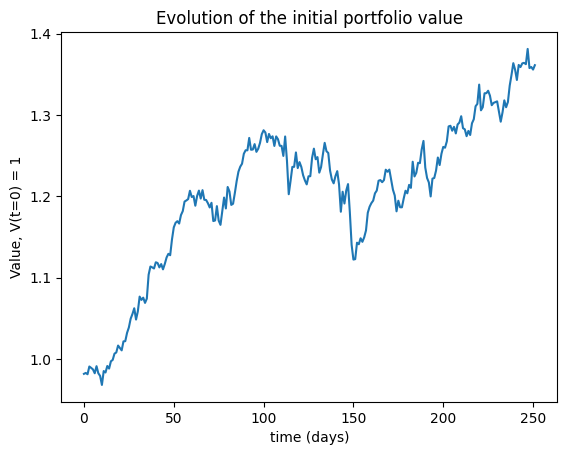

In [58]:
# Overlook of initial portfolio
portfolio_value = cvx.cumprod(1 + returns.iloc[:T_w_init]@w_0 )
print(f'Portfolio Raw Retrun: {portfolio_value.value[-1]:.3f}')
plt.plot(portfolio_value.value)
plt.title("Evolution of the initial portfolio value")
plt.xlabel('time (days)')
plt.ylabel('Value, V(t=0) = 1')
plt.show()

## Dynamic re-allocation

In [55]:
def realocation(returns_df, T_w=252, dt=1, w_max = 0.2, var_max = 5e-4,turnover =0.03):
    T_max,N = returns_df.shape

    # Feasability check
    if T_w>T_max:
        print('Time window too long compare to the given data:')
        print('Window length:',T_w)
        print('Data length: ', T_max)
        return

    # Weights storage
    w_0 = init_weights(returns_df,T_w=T_w,w_max=w_max,var_max=var_max)
    weights_evol = [w_0]

    # Value storage
    V = [1]

    t = T_w
    w = cvx.Variable(N)
    while t+dt<T_max:

        # Update portfolio value during the time step dt where the weights are fixed
        for k in range(t,t+dt):
            weights_evol.append(w_0)

            r = returns_df.iloc[k]@w_0
            V.append(V[-1]*(1+r))

        # Go forward by one time step
        t = t+dt        

        # Set new window of the past Tw days
        portfolio_returns_w = returns_df.iloc[t-T_w:t].to_numpy() @ w

        # Expected log-growth
        g = cvx.mean( cvx.log( 1 + portfolio_returns_w ) , axis=0)

        # Volatility as variance 
        variance = cvx.var(portfolio_returns_w)

        # Problem formulation
        objective = cvx.Maximize(g)
        constraints = [w>=0, cvx.sum(w)==1,w<=w_max,variance<= var_max, cvx.norm1(w-w_0)<=turnover]
        kelly_opt = cvx.Problem(objective=objective,constraints=constraints)
        kelly_opt.solve()

        # Update weights
        w_0 = np.round(w.value,4)
            
    # Uptade weight and portfolio value for the remaining time
    for k in range(t,T_max):
        weights_evol.append(w_0)

        r = returns_df.iloc[k]@w_0
        V.append(V[-1]*(1+r))

    return weights_evol,V


weights_evol,V = realocation(returns)      

c:\Users\verne\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


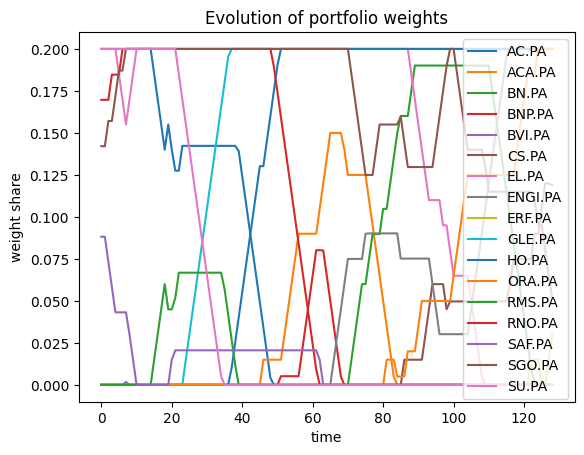

In [59]:
# Display weights
weights_evol = pd.DataFrame(np.array(weights_evol),columns=tickers)
weights_evol.loc[:, (weights_evol != 0).any(axis=0)].plot()
plt.title('Evolution of portfolio weights')
plt.xlabel('time')
plt.ylabel('weight share')
plt.show()

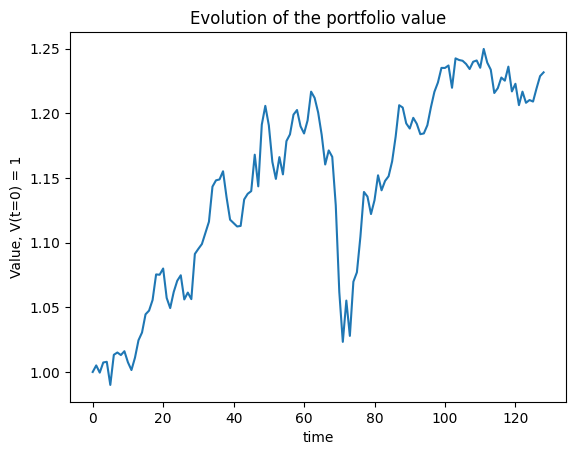

In [57]:
plt.plot(np.arange(129),V)
plt.title('Evolution of the portfolio value')
plt.xlabel('time')
plt.ylabel('Value, V(t=0) = 1')
plt.show()

# Results analysis

## Influence of the time window

## Influence of the time step

## Influence of the holding constraint

## Influence of the variance limit

## Influence of the turnover constraint